# Regressão Logística

   Códigos necessários para esse curso.   
   Foco na interpretação dos resultados! 
   
   Legendas:
   * <code style="color:green">Explicação Conteúdo</code>
   * <code style="color:purple">Dicas</code>
   * <code style="color:red">Prática</code>
   * <code style="color:gray">Contexto Negócio</code>


### <code style="color:green"> Regressão Logística

    É uma generalização da Regressão Linear, por isso faz parte da família dos modelos lineares generalizados.
    - gera a probabilidade do evento de interesse
    - método de máxima verossimilhança
    - intepretação pela odds ratio (exponencial do parâmetro)

In [1]:
#carregando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import statistics
import math
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn
from sklearn.metrics import roc_curve, auc

In [2]:
#assim como na regressão linear, criamos funções personalizadas para os métodos de seleção de variáveis
#carregando funções, todas de uma vez

from funcoes_importantes_regressao_logistica import step,univariada_variavel_numerica,univariada_variavel_categoria,analise_var_numerica_por_percentil

### <code style="color:gray">Contexto Negócio </code>
    
    Um navio naufragou e estamos tentando entender quais foram os critérios utilizados por eles, para definir quem eram os seres que usariam os botes disponíveis!
    Conseguem nos ajudar a entender esses fatores?
    
dados: titanic.sas7bdat
    

In [3]:
#importando base titanic
titanic = pd.read_sas("dados/titanic.sas7bdat", format = "sas7bdat", encoding="iso-8859-1")
titanic

,Name,Age,Gender,Class,Fare,Survival
0,"Allen, Miss. Elisabeth Walton",29.0,Female,1.0,211.34,1.0
1,"Allison, Master. Hudson Trevor",1.0,Male,1.0,151.55,1.0
2,"Allison, Miss. Helen Loraine",2.0,Female,1.0,151.55,0.0
3,"Allison, Mr. Hudson Joshua Creighton",30.0,Male,1.0,151.55,0.0
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0,Female,1.0,151.55,0.0
...,...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",15.0,Female,3.0,14.45,0.0
1305,"Zabour, Miss. Thamine",NaN,Female,3.0,14.45,0.0
1306,"Zakarian, Mr. Mapriededer",27.0,Male,3.0,7.23,0.0
1307,"Zakarian, Mr. Ortin",27.0,Male,3.0,7.23,0.0


### <code style="color:purple"> Discutindo Atuação </code>
    
    O primeiro passo é sempre interessante entender um pouco mais sobre os dados e nada melhor do que começar a cronstruir o nosso "mapa astral" dos dados. Vamos descrevê-los e pensar no que precisamos nos preocupar em relação a cada variável?
    
    Dicionário de dados:
    
| Variável  | Descrição   | Pensamento   |
| :------- | :-------- | :-------- |
| Name   | Nome do Passageiro    | O nome não irá nos ajudar no modelo, certo? Serve apenas para identificação. |
| Age   | Idade | Como será a distribuição dessa variável? Tem missing? | 
| Gender   | Sexo do passageiro | Quais são as opções que existem nessa variável? Como está a frequência para cada um dos níveis possíveis? Tem missing? | 
| Class   | Classe no Navio | Qual a classe que o passageiro estava alocado? Quantos níveis existem? |
| Fare | Valor pago pela viagem | Como será a distribuição dessa variável? Tem missing? Faz sentido com a variável anterior? |
| Survival | Marcação de quem sobreviveu (1) e quem não (0) | Existe missing? Qual a frequência de cada nível? |

De uma forma ampla, comecei analisando se existem dados faltantes em alguma variável:

In [4]:
# observando missing nas variáveis
titanic.isnull().sum()

Name          0
Age         263
Gender        0
Class         0
Fare          1
Survival      0
dtype: int64

In [5]:
# Calcular percentual de valores ausentes para cada variável
titanic.isna().sum()/titanic.shape[0] * 100

Name         0.000000
Age         20.091673
Gender       0.000000
Class        0.000000
Fare         0.076394
Survival     0.000000
dtype: float64

### <code style="color:purple">COMENTÁRIOS:</code>

- Note que temos valores ausentes nas variáveis Age e Fare.

Vamos explorar as variáveis:

### <code style="color:green"> Análise Univariada das Variáveis</code>

Vamos realizar uma análise descritiva univariada dacada uma das nossas variáveis na base de dados.

### <code style="color:green">Variável: Idade</code>

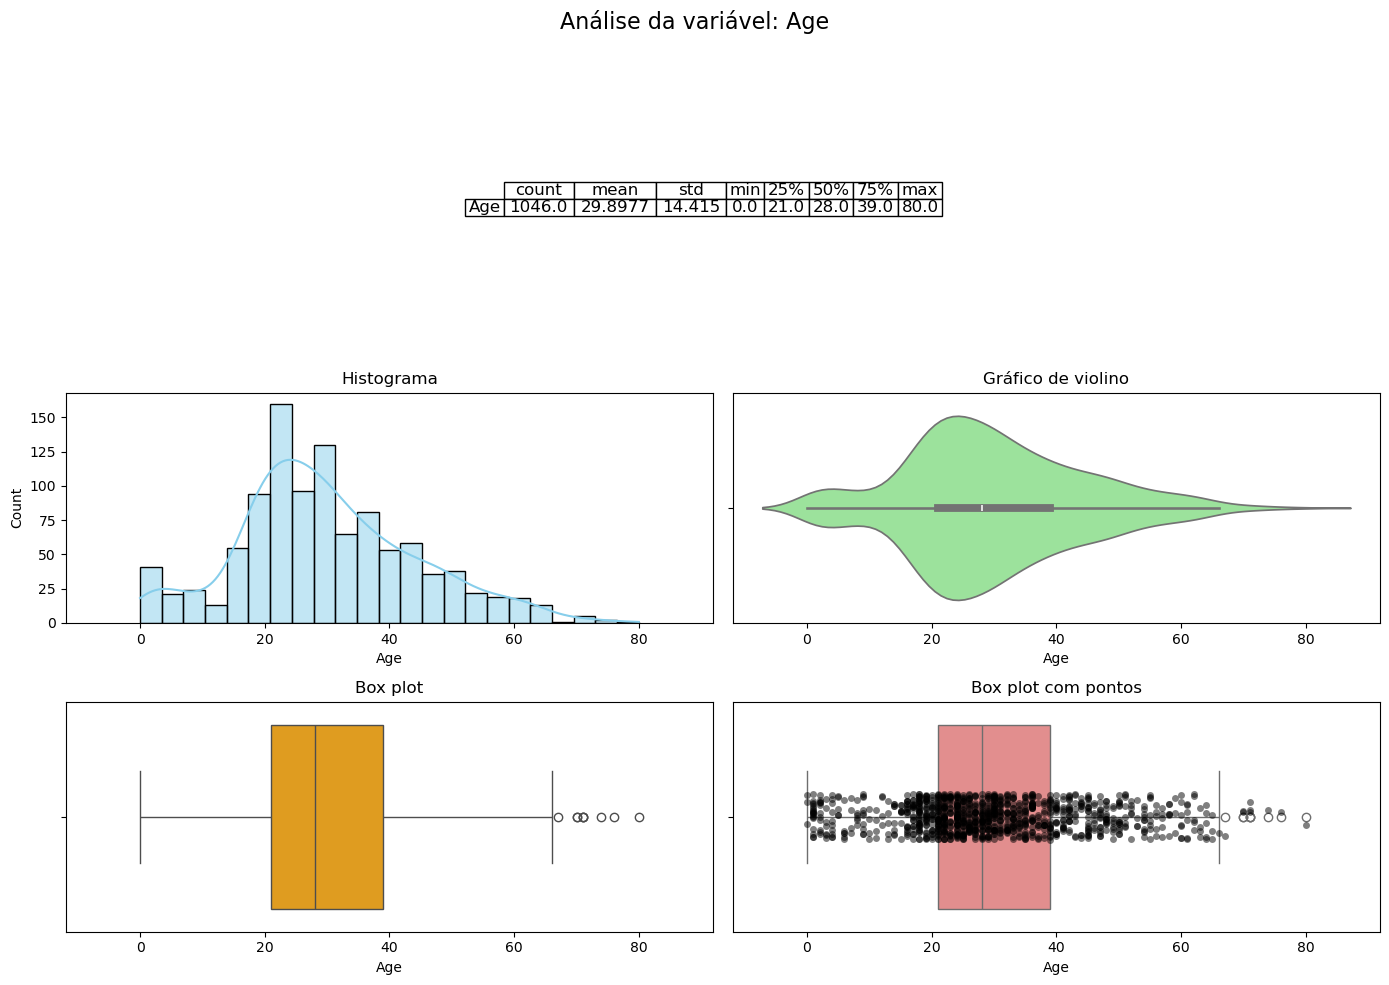

In [6]:
#utilizando a função de análise descritiva para uma variável contínua
#função para análise descritiva e gráfica de uma variável contínua.
univariada_variavel_numerica(titanic, "Age")

### <code style="color:green">Variável: Gender</code>

Describe da variável categórica:


,count,unique,top,freq
Gender,1309,2,Male,843


Tabela de frequência da variável categórica (com percentuais e total):


,Gender,Frequência,Percentual (%)
0,Male,843,64.4
1,Female,466,35.6
2,Total,1309,100.0


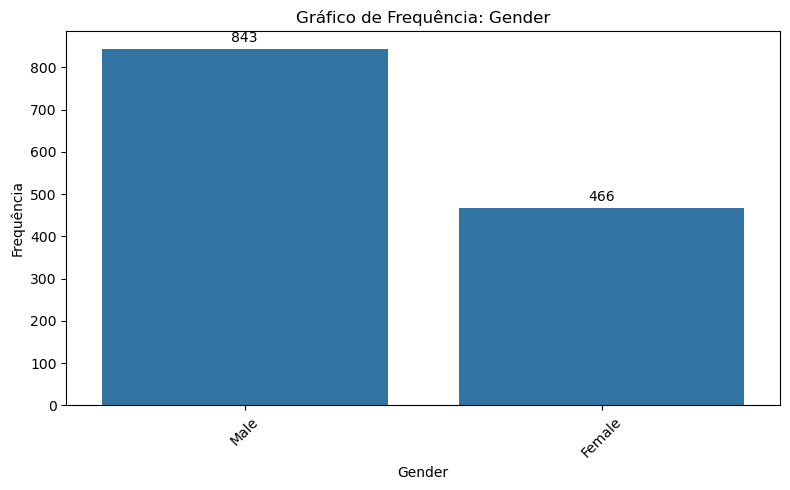

In [7]:
#utilizando a função de análise descritiva para uma variável categórica
#Ela tem por objetivo te ajudar na sua exploratória de dados.
#Essa função cria o describe, uma tabela de frequência e um gráfico de barras.
univariada_variavel_categoria(titanic, "Gender")

### <code style="color:green">Variável: Class</code>

Describe da variável categórica:


,count,unique,top,freq
Class,1309.0,3.0,3.0,709.0


Tabela de frequência da variável categórica (com percentuais e total):


,Class,Frequência,Percentual (%)
0,3.0,709,54.16
1,1.0,323,24.68
2,2.0,277,21.16
3,Total,1309,100.00


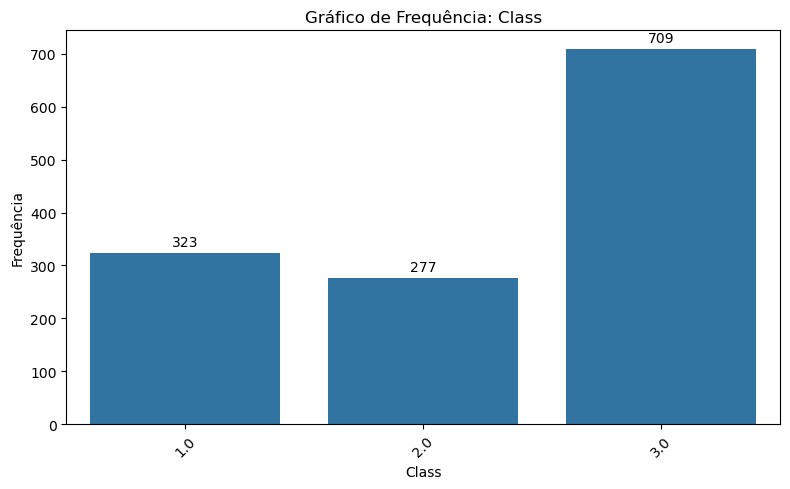

In [8]:
# Converte a variável "Class" para categórica
titanic["Class"] = titanic["Class"].astype("category")
#utilizando a função de análise descritiva para uma variável categórica
univariada_variavel_categoria(titanic, "Class")

### <code style="color:green">Variável: Fare</code>

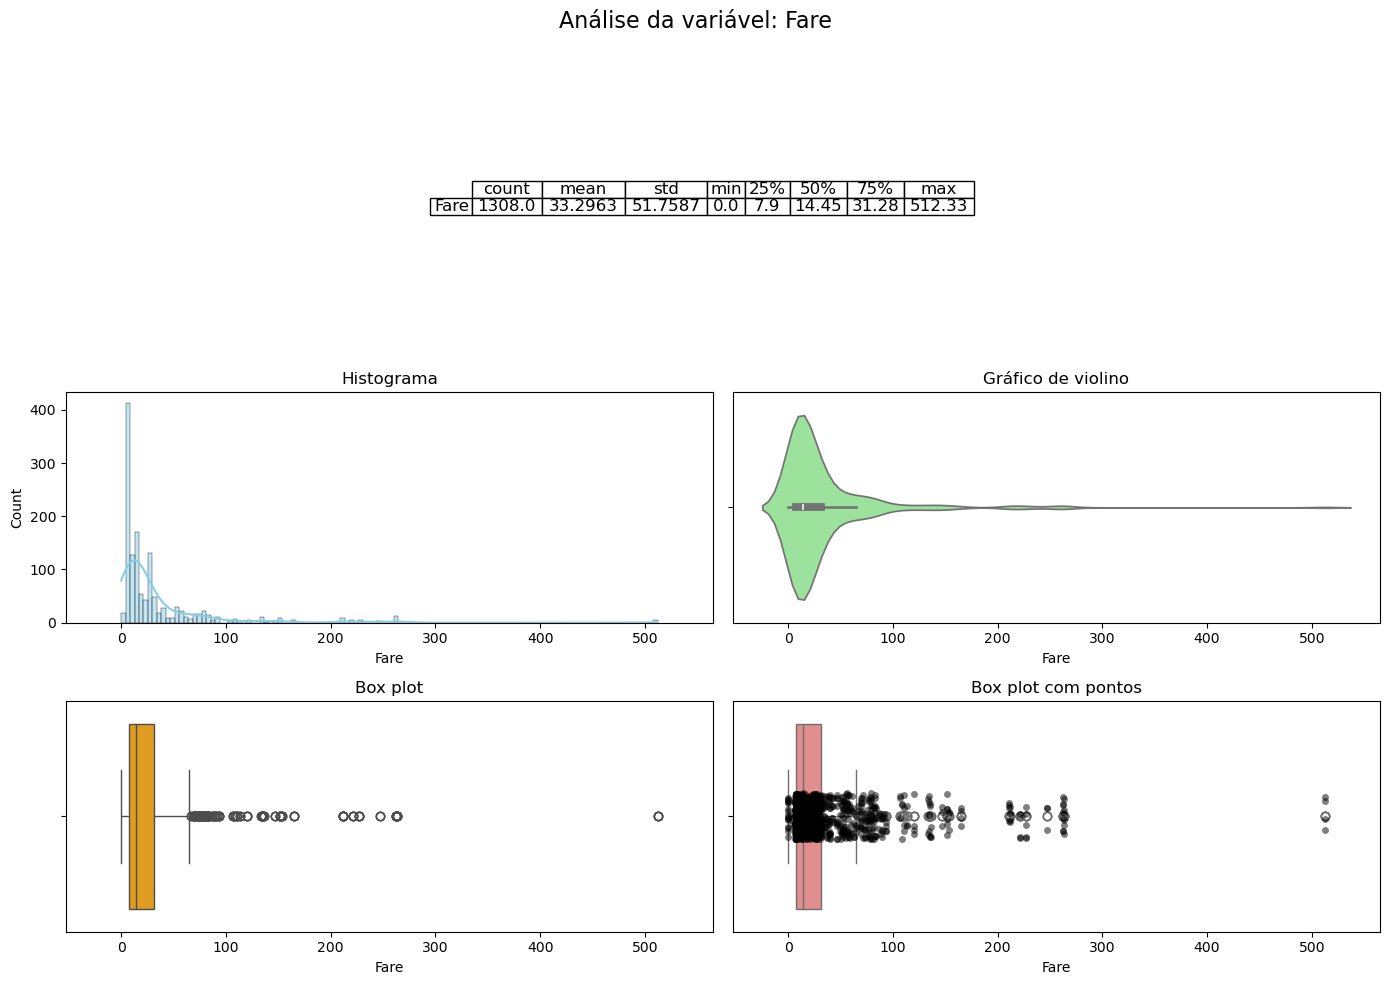

In [9]:
#utilizando a função de análise descritiva para uma variável contínua
univariada_variavel_numerica(titanic, "Fare")

### <code style="color:green">Variável: Survival</code>

Describe da variável categórica:


,count,unique,top,freq
Survival,1309.0,2.0,0.0,809.0


Tabela de frequência da variável categórica (com percentuais e total):


,Survival,Frequência,Percentual (%)
0,0.0,809,61.8
1,1.0,500,38.2
2,Total,1309,100.0


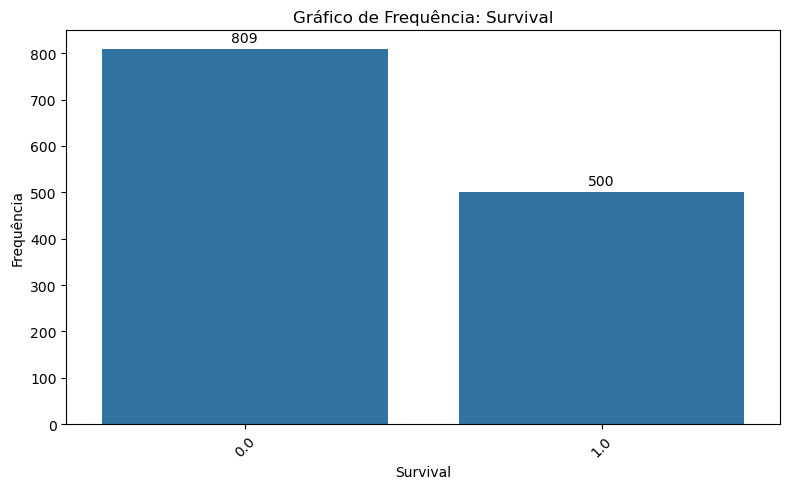

In [10]:
# Converte a variável "Survival" para categórica
titanic["Survival"] = titanic["Survival"].astype("category")
#utilizando a função de análise descritiva para uma variável categórica
univariada_variavel_categoria(titanic, "Survival")

### <code style="color:purple"> Atualizando a Atuação </code>
    
   Podemos ajustar nosso dicionário, com nossos novos aprendizados
    
| Variável  | Descrição   | Comentários   |
| :------- | :-------- | :-------- |
| Name   | Nome do Passageiro    |  |
| Age   | Idade | Tem 263 missingins. Distribuição levemente assimétrica a direita. Tem relação linear com logito de p?| 
| Gender   | Sexo do passageiro | Não existe missing, temos mais homens do que mulheres, não tem classe com n muito pequeno. | 
| Class   | Classe no Navio | Não existe missing, transformei em caracter, são 3 classes. A classe 3 tem  o dobro das outras.|
| Fare | Valor pago pela viagem | Tem 1 missing. Distribuição bem assimétrica a direita. Tem relação linear com logito de p? |
| Survival | Marcação de quem sobreviveu (1) e quem não (0) | Não tem missing. Transformei em categórica. 61,80 % de mortes (0) e 38,20% de sobreviventes (1) |

### <code style="color:green"> Análise Bivariada das Variáveis</code>

Vamos explorar a relação entre as variáveis?
Alumas perguntas que podemos responder:

- Existe uma relação linear entre Age e Fare, com o logito de p?
- Se existe missing, o que fazer com eles?
- Existe relação entre Fare e Class? Será que as médias são diferentes? (se forem, precisamos colocar as duas no modelo?)
- Como é a distribuição do Gender, Age e Class por Survival?

<code style="color:purple">1) Começando pela idade</code>

C:\Users\adria\AppData\Local\Temp\ipykernel_16596\665608711.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idade_sum_sm = df_age_cm.groupby('percentil_idade').agg(


,percentil_idade,n,min_age,max_age,mean_survival,logito_p
0,10,131,0.0,16.0,0.557252,0.230016
1,20,131,16.0,21.0,0.358779,-0.580669
2,30,131,21.0,24.0,0.381679,-0.482426
3,40,131,24.0,28.0,0.351145,-0.614010
4,50,131,28.0,32.0,0.404580,-0.386417
5,60,131,32.0,39.0,0.427481,-0.292136
6,70,131,39.0,48.0,0.351145,-0.614010
7,80,129,48.0,80.0,0.435115,-0.261014
8,90,0,NaN,NaN,0.282443,-0.932377
9,100,0,NaN,NaN,0.269231,-0.998529


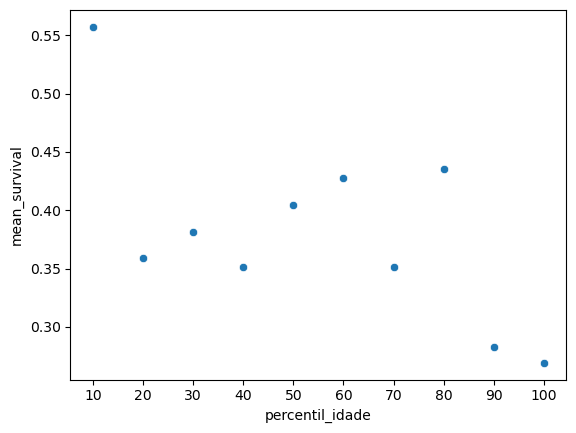

In [11]:
# começarei verificando a linearidade entre Age e logito de p

# criando uma copia para manipular o que importa
df_age_cm = titanic[['Survival', 'Age']].copy()
# ordenando pela Idade
df_age_cm = df_age_cm.sort_values("Age").reset_index()
# criando uma variavel com o n_total da base
n_total = df_age_cm['Survival'].count()
# criando a variavel percentil da idade, de 10 em 10 %
df_age_cm['percentil_idade']=pd.cut(
   df_age_cm.index,
   bins=[-1, (n_total/10), (n_total/10)*2, (n_total/10)*3, (n_total/10)*4, (n_total/10)*5, (n_total/10)*6, 
         (n_total/10)*7, (n_total/10)*8, (n_total/10)*9, sys.maxsize],
   labels=['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']
)

# Certificar-se de que a variável y está no formato numérico
df_age_cm["Survival"] = pd.to_numeric(df_age_cm["Survival"], errors='coerce')

# Adicionando cálculo de n, min_age, max_age, média de survival e logito_p
idade_sum_sm = df_age_cm.groupby('percentil_idade').agg(
    n=('Age', 'count'),                     # Número de linhas
    min_age=('Age', 'min'),                 # Mínimo de Age
    max_age=('Age', 'max'),                 # Máximo de Age
    mean_survival=('Survival', 'mean')      # Média de Survival
).reset_index()

# Calculando logito_p
epsilon = 1e-10  # Para evitar 0 e 1
idade_sum_sm['logito_p'] = np.log(np.clip(idade_sum_sm['mean_survival'], epsilon, 1 - epsilon) / 
                                  (1 - np.clip(idade_sum_sm['mean_survival'], epsilon, 1 - epsilon)))

# Exibindo a tabela resultante
idade_sum_sm

# fazendo o gráfico de dispersão para p
sns.scatterplot(x="percentil_idade",y="mean_survival",data=idade_sum_sm)
idade_sum_sm

<AxesSubplot:xlabel='percentil_idade', ylabel='logito_p'>

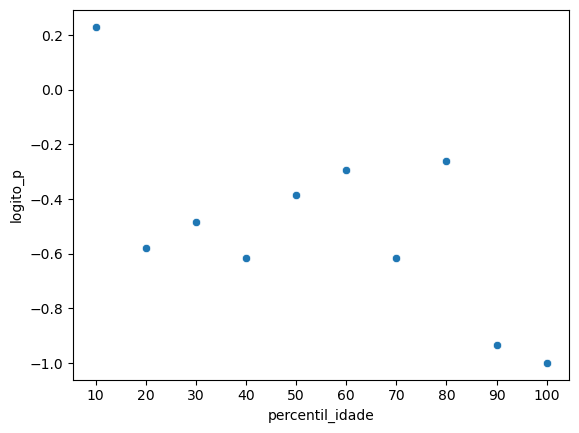

In [12]:
sns.scatterplot(x="percentil_idade",y="logito_p",data=idade_sum_sm)

### <code style="color:purple">COMENTÁRIOS:</code>

Como visto, a taxa de resposta de até 16 anos é diferente das demais.
Notamos também que os dados faltantes estão com taxa de resposta parecida. Pensando nisso, decidimos agrupar a idade em 3 grupos (variável: `Age`):

- **Menor_16**
- **Maior_16**
- **Sem_idade**

In [13]:
#criando o agrupamento
titanic['Age_C'] = pd.cut(
    titanic['Age'],
    bins=[-float('inf'), 17, float('inf')],
    labels=['Menor_16', 'Maior_16'],
    ordered=False
) # criando a variável categórica para identificar se é menor de 16 anos ou maior

# atualizando a variável categórica para incluir as pessoas que não tem idade
titanic['Age_C'] = np.where(titanic['Age_C'].isna(), 'Sem_idade', titanic['Age_C'].astype(str)) 
titanic

,Name,Age,Gender,Class,Fare,Survival,Age_C
0,"Allen, Miss. Elisabeth Walton",29.0,Female,1.0,211.34,1.0,Maior_16
1,"Allison, Master. Hudson Trevor",1.0,Male,1.0,151.55,1.0,Menor_16
2,"Allison, Miss. Helen Loraine",2.0,Female,1.0,151.55,0.0,Menor_16
3,"Allison, Mr. Hudson Joshua Creighton",30.0,Male,1.0,151.55,0.0,Maior_16
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0,Female,1.0,151.55,0.0,Maior_16
...,...,...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",15.0,Female,3.0,14.45,0.0,Menor_16
1305,"Zabour, Miss. Thamine",NaN,Female,3.0,14.45,0.0,Sem_idade
1306,"Zakarian, Mr. Mapriededer",27.0,Male,3.0,7.23,0.0,Maior_16
1307,"Zakarian, Mr. Ortin",27.0,Male,3.0,7.23,0.0,Maior_16


In [14]:
# verificando a quantidade e taxa de resposta no grupo

# Certificar-se de que a variável y está no formato numérico
titanic["Survival"] = pd.to_numeric(titanic["Survival"], errors='coerce')

titanic.groupby('Age_C').agg(
    n = ('Survival','count'),
    tx_resposta = ('Survival','mean')
)

,n,tx_resposta
Age_C,,
Maior_16,892,0.387892
Menor_16,154,0.525974
Sem_idade,263,0.277567


<code style="color:purple">1) Conclusão da idade</code>

Essa nova variável foi criada, pois como pudermos ver, a variável Age não tinha uma relação linear com o logito de p.   
Decidimos categorizar em 3 grupos, visto o momento da taxa de resposta observada por percentis da idade.   
Escolheu-se por agrupar os "sem idade" (nan), pois tinham uma taxa diferente dos outros 2 grupos.   

<code style="color:purple">Atualizando o dicionário de dados:</code>

| Variável  | Descrição   | Comentários   |
| :------- | :-------- | :-------- |
| Name   | Nome do Passageiro    |  |
| Idade   | Faixa de Idade | Não tem missing, são 3 grupos com taxas de respostas bem diferentes.| 
| Gender   | Sexo do passageiro | Não existe missing, temos mais homens do que mulheres, não tem classe com n muito pequeno. | 
| Class   | Classe no Navio | Não existe missing, transformei em caracter, são 3 classes. A classe 3 tem  o dobro das outras.|
| Fare | Valor pago pela viagem | Tem 1 missing. Distribuição bem assimétrica a direita. Tem relação linear com o logito de p? |
| Survival | Marcação de quem sobreviveu (1) e quem não (0) | Não tem missing. Transformei em categórica. 61,80 % de mortes (0) e 38,20% de sobreviventes (1) |


<code style="color:purple">Voltando à análise:</code>

Vamos explorar a relação entre as variáveis?
Alumas perguntas que podemos responder:

- Existe uma relação linear entre Age e Fare, com o logito de p?
- Se existe missing, o que fazer com eles?

<code style="color:purple">2) Partindo para Fare</code>

Faremos as mesmas análises, mas agora utilizarei a função pronta

C:\Users\adria\AppData\Local\Temp\ipykernel_16596\2119855495.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['Fare'].fillna(0, inplace=True)
C:\Users\adria\Documents\1_Scripts_Python\IDA_organizado\4_Regressao_Logistica\gravar\funcoes_importantes_regressao_logistica.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary

<Figure size 1200x600 with 0 Axes>

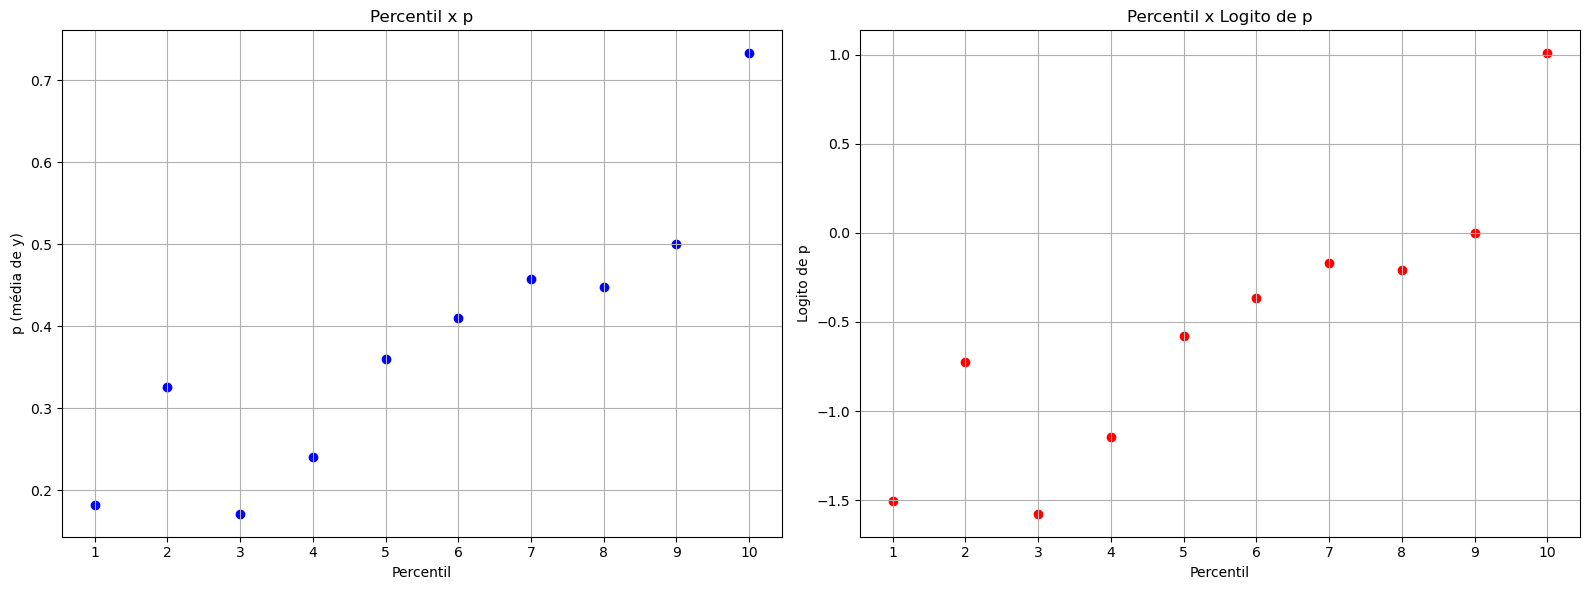

,percentil,n,min_x,max_x,p,logito_p
0,1,132,0.00,7.55,0.181818,-1.504077
1,2,144,7.58,7.85,0.326389,-0.724563
2,3,146,7.88,8.05,0.171233,-1.576915
3,4,108,8.11,10.50,0.240741,-1.148623
4,5,128,10.52,14.45,0.359375,-0.578078
5,6,127,14.46,21.08,0.409449,-0.366244
6,7,131,21.68,26.55,0.458015,-0.168335
7,8,134,27.00,41.58,0.447761,-0.209721
8,9,128,42.40,77.96,0.500000,0.000000
9,10,131,78.27,512.33,0.732824,1.009000


In [15]:
#sabemos que esta variável tem um missing, e como sabemos que é o dono do barco, vou imputar Fare=0 neste caso (decisão baseada no contexto)
titanic['Fare'].fillna(0, inplace=True)
# utilizando a função pronta para verificar o comportamento do logito de p.
#Ou seja, ordena o x, cria percentis, calcula p e o logito de p, além de fazer o gráfico.
#Essa função ignora os valores faltantes, e ela faz a divisão por percentis pensando nos valores repetidos do x.
#Ou seja, podem existir percentis com volumes diferentes, pois o corte está sendo realizado nos valores de x.

analise_var_numerica_por_percentil(titanic, 'Fare', 'Survival', q=10, grafico='ambos')

<code style="color:purple">2) Seguindo com Fare</code>

Como podemos ver, essa sim tem uma relação linear com o logito de p, ou seja, pode ser utilizada como número no modelo!
No entanto, me surge a curiosidade de que Fare e a variável Class sejam a mesma coisa!!!

Vamos verificar como é a distribuição da Fare para cada uma das classes (variável: Class)


<AxesSubplot:xlabel='Class', ylabel='Fare'>

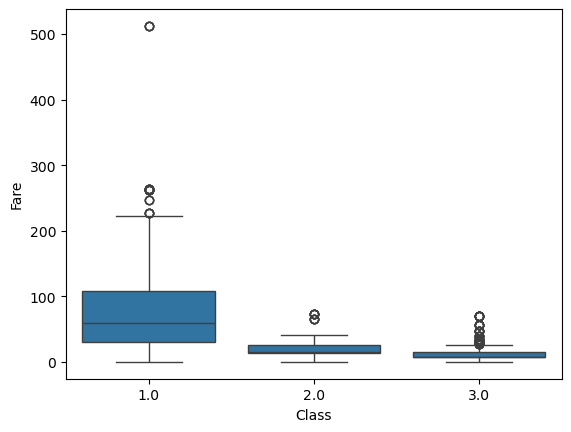

In [16]:
#Relacao de Survival com a variavel numerica Fare
sns.boxplot(x="Class", y="Fare", data=titanic)

### <code style="color:purple">COMENTÁRIOS:</code>


- Olhando o boxplot podemos ver que que a variabilidade é diferente para cada uma das classes!

- Vamos fazer um gráfico de densidade para poder observar a distribuição

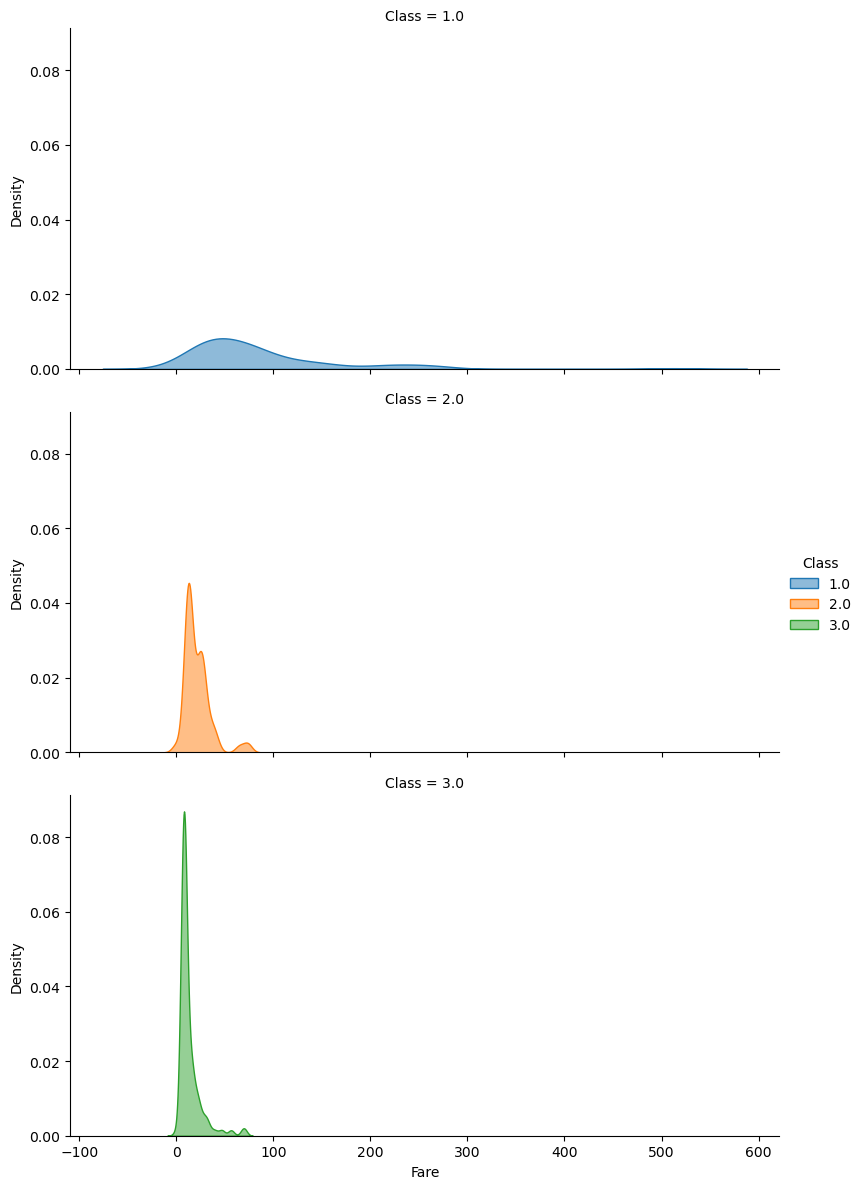

In [17]:
#grafico de densidade para cada Classe
g = sns.FacetGrid(titanic, col="Class", col_wrap=1,hue = 'Class', height=4, aspect=2)
g.map(sns.kdeplot, "Fare", fill=True, alpha=0.5)

# Ajustar o layout
g.add_legend()
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Realmente parece que as médias são diferentes e lembre que se as médias são diferentes é porque existe algum tipo de associação!

- Vamos fazer a anova e depois o teste t para verificar, mas antes precisamos validar a normalidade (o que não parece ser)

In [18]:
# Shapiro - teste de normalidade para cada Classe
# H0: a distribuição é normal
# H1: a distribuição não é normal
estatistica_class_1, p_valor_class_1 = stats.shapiro(titanic[titanic['Class'] == 1.0]['Fare'])
estatistica_class_2, p_valor_class_2 = stats.shapiro(titanic[titanic['Class'] == 2.0]['Fare'])
estatistica_class_3, p_valor_class_3 = stats.shapiro(titanic[titanic['Class'] == 3.0]['Fare'])

print('Valor-p teste normalidade class 1:', p_valor_class_1)
print('Valor-p teste normalidade class 2:', p_valor_class_2)
print('Valor-p teste normalidade class 3:', p_valor_class_3)

Valor-p teste normalidade class 1: 5.82082666598652e-22
Valor-p teste normalidade class 2: 3.257721222684423e-19
Valor-p teste normalidade class 3: 1.1344407912545618e-37


### <code style="color:purple">COMENTÁRIOS:</code>

- Como não é normal (nenhuma delas), não poderiamos usar a ANOVA, então vamos usar o teste Kruskal Wallis!
- Lembre-se que temos uma observação faltante em Fare! E o teste de Kruskal Wallis no Python não permite que tenha dados faltantes!
- Nesse caso vamos imputar essa observação pela Média do seu Class!

In [19]:
# Aplicar o teste de Kruskal-Wallis
# H0: mediana_class1 = mediana_class2 = mediana_class3
# H1: pelo menos 1 diferente  
estatistica, p_valor = stats.kruskal(titanic[titanic['Class'] == 1.0]['Fare'],
                        titanic[titanic['Class'] == 2.0]['Fare'],
                        titanic[titanic['Class'] == 3.0]['Fare']
                       )

print(f'Estatística do teste: {estatistica}')
print(f'Valor-p: {p_valor}')

Estatística do teste: 676.2847853975237
Valor-p: 1.4016021446779482e-147


### <code style="color:purple">COMENTÁRIOS:</code>

- Rejeitamos $H_{0}$, ou seja, pelo menos uma das medianas são diferentes!
 
- Vamos verificar o teste de Mann-Whitney de comparação de médias entre class 1 com a 2

In [20]:
# vamos verificar o teste de Mann-Whitney de comparação de médias entre class 1 com a 2
# H0: mediana_class1 - mediana_class2 = 0
# H1: mediana_class1 - mediana_class2 <> 0
estatistica, p_valor = stats.mannwhitneyu(titanic['Fare'][titanic['Class'] == 1.0],
                                          titanic['Fare'][titanic['Class'] == 2.0], alternative='two-sided')

print(f'Estatística do teste: {estatistica}')
print(f'Valor-p: {p_valor}')


Estatística do teste: 81640.0
Valor-p: 3.467209960390082e-68


### <code style="color:purple">COMENTÁRIOS:</code>

- Rejeitamos $H_{0}$, ou seja, as medianas são diferentes!
- Vamos verificar o teste de Mann-Whitney de comparação de médias entre class 1 com a 3

In [21]:
# vamos verificar o teste de Mann-Whitney de comparação de médias entre class 1 com a 3
# H0: mediana_class1 - mediana_class3 = 0
# H1: mediana_class1 - mediana_class3 <> 0
estatistica, p_valor = stats.mannwhitneyu(titanic['Fare'][titanic['Class'] == 1.0],
                                          titanic['Fare'][titanic['Class'] == 3.0], alternative='two-sided')

print(f'Estatística do teste: {estatistica}')
print(f'Valor-p: {p_valor}')


Estatística do teste: 216827.5
Valor-p: 1.3734193401809274e-117


### <code style="color:purple">COMENTÁRIOS:</code>

- Rejeitamos $H_{0}$, ou seja, as medianas são diferentes!
- Vamos verificar o teste de Mann-Whitney de comparação de médias entre class 2 com a 3

In [22]:
# vamos verificar o teste de Mann-Whitney de comparação de médias entre class 2 com a 3
# H0: mediana_class2 - mediana_class3 = 0
# H1: mediana_class2 - mediana_class3 <> 0
estatistica, p_valor = stats.mannwhitneyu(titanic['Fare'][titanic['Class'] == 2.0],
                                          titanic['Fare'][titanic['Class'] == 3.0], alternative='two-sided')

print(f'Estatística do teste: {estatistica}')
print(f'Valor-p: {p_valor}')


Estatística do teste: 154041.0
Valor-p: 6.175620646084026e-44


<code style="color:purple">2) Conclusão da Fare</code>

Como podemos ver, ela tem uma relação linear com o logito, podendo assim entrar no modelo como uma variável numérica! No entanto, fica claro que a variável Fare tem uma relação direta com a variável Class.

Sendo assim, devemos ficar atentos a isso na hora de criar o modelo. As duas juntas pode se não ser uma boa opção!

<code style="color:purple">Atualizando o dicionário de dados:</code>

| Variável  | Descrição   | Comentários   |
| :------- | :-------- | :-------- |
| Name   | Nome do Passageiro    |  |
| Idade   | Faixa de Idade | Não tem missing, são 3 grupos com taxas de respostas bem diferentes.| 
| Gender   | Sexo do passageiro | Não existe missing, temos mais homens do que mulheres, não tem classe com n muito pequeno. | 
| Class   | Classe no Navio | Não existe missing, transformei em caracter, são 3 classes. A classe 3 tem  o dobro das outras.|
| Fare | Valor da passagem | Tem uma relação linear com y, mas não deveria ser utilizada junto com Class |
| Survival | Marcação de quem sobreviveu (1) e quem não (0) | Não tem missing. Transformei em categórica. 61,80 % de mortes (0) e 38,20% de sobreviventes (1) |


<code style="color:purple">Voltando à análise:</code>

Vamos explorar a relação entre as variáveis?
Alumas perguntas que podemos responder:

- Como é a distribuição do Gender, Age e Class por Survival?

<code style="color:purple">3) Entendendo um pouco mais da relação entre as variáveis categóricas</code>

Para visualizar comportamento das categóricas juntas, podemos estudar gráficos de barras e a estatística cramer´s V

* <code style="color:purple">Variável Class</code>

<AxesSubplot:xlabel='Class', ylabel='count'>

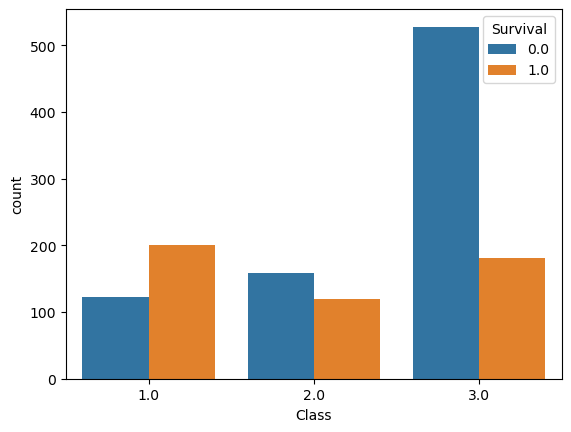

In [23]:
sns.countplot(data=titanic, x='Class', hue='Survival', dodge=True)

### <code style="color:purple">COMENTÁRIOS:</code>

- Veja que a maioria dos tripulantes que morreram são das terceira classe!
- Existe inversão de barras conforme a classe, o que demonstra que essa variável pode ser muito interessante
- Vamos calcular o qui-quadrado e Cramer´s V

In [24]:
#Calculando a relacao de Class com Survival atraves do Cramer´s V

class_qui = pd.crosstab(titanic['Survival'], titanic['Class'])
chi2, p_valor, df, freq_esperada = stats.chi2_contingency(class_qui)
print(f'p-valor do qui-quadrado: {p_valor}')

#calculando Cramer's V conforme a fórmula
n =  titanic.shape[0]
min_dim = min(class_qui.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f'Cramér\'s V: {cramers_v}')

p-valor do qui-quadrado: 1.7208259588256052e-28
Cramér's V: 0.31253315355294775


* <code style="color:purple">Variável Class - resumo</code>

Notamos que é uma variável que pode ser muito útil visto que existem diferenças bizarras entre 0 e 1´s em cada uma das classes.   
A correlação com y é de 0,3125

* <code style="color:purple">Variável Gender</code>

<AxesSubplot:xlabel='Gender', ylabel='count'>

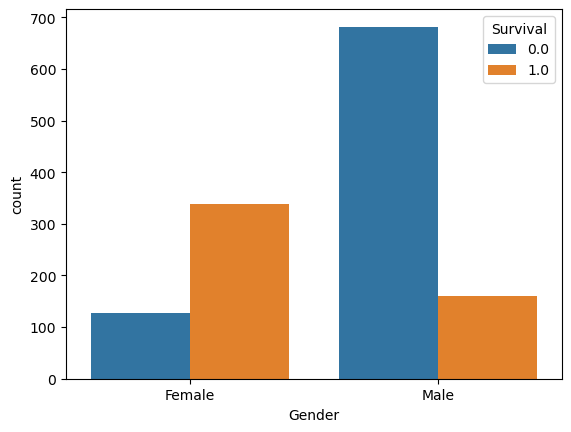

In [25]:
#Para a variavel Gender
sns.countplot(data=titanic, x='Gender', hue='Survival', dodge=True)

### <code style="color:purple">COMENTÁRIOS:</code>

- Perceba que os homens tem a maior frequência de não sobreviventes!
- Existe inversão de barras conforme Gender, o que demonstra que essa variável pode ser muito interessante
- Vamos calcular o qui-quadrado e Cramer´s V

In [26]:
#Calculando a relacao de Gender com Survival atraves do Cramer´s V
class_qui = pd.crosstab(titanic['Survival'], titanic['Gender'])
chi2, p_valor, df, freq_esperada = stats.chi2_contingency(class_qui)
print(f'p-valor teste qui-quadrado: {p_valor}')

#calculando Cramer's V conforme a fórmula
n =  titanic.shape[0]
min_dim = min(class_qui.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f'Cramér\'s V: {cramers_v}')

p-valor teste qui-quadrado: 4.589924936952945e-81
Cramér's V: 0.5270512029599221


* <code style="color:purple">Variável Gender - resumo</code>

Notamos que é uma variável que pode ser até mais útil visto que existem diferenças bizarras entre 0 e 1´s em cada uma das classes.   
A correlação com y é de 0,5270

* <code style="color:purple">Variável Idade (Age_C)</code>

<AxesSubplot:xlabel='Age_C', ylabel='count'>

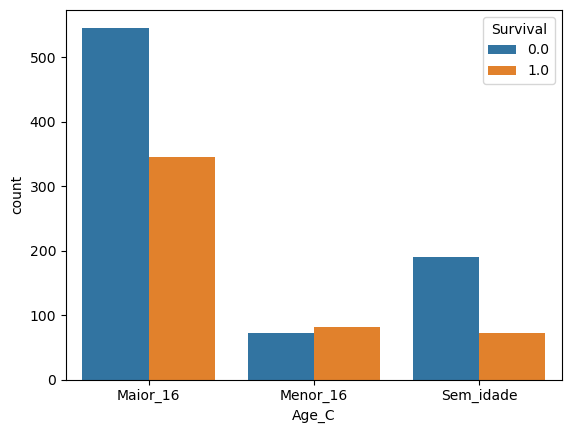

In [27]:
#Para a variavel Age_C
sns.countplot(data=titanic, x='Age_C', hue='Survival', dodge=True)

### <code style="color:purple">COMENTÁRIOS:</code>

- Perceba que os tripulantes que tem idade maior que 16 anos possuem uma frequência maior de morte!
- Existe inversão de barras conforme Age_C, o que demonstra que essa variável pode ser muito interessante (menos que as duas anteriores)
- Vamos calcular o qui-quadrado e Cramer´s V

In [28]:
#Calculando a relacao de Gender com Survival atraves do Cramer´s V
class_qui = pd.crosstab(titanic['Survival'], titanic['Age_C'])
chi2, p_valor, df, freq_esperada = stats.chi2_contingency(class_qui)
print(f'p-valor teste qui-quadrado: {p_valor}')

#calculando Cramer's V conforme a fórmula
n =  titanic.shape[0]
min_dim = min(class_qui.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f'Cramér\'s V: {cramers_v}')

p-valor teste qui-quadrado: 2.4930462874309627e-06
Cramér's V: 0.14040215723051205


* <code style="color:purple">Variável Idade - resumo</code>

Notamos que é uma variável pouco útil visto que não existem diferenças bizarras entre 0 e 1´s em cada uma das classes.   
A correlação com y é de 0,1404 (repare que é a mais baixa)

<code style="color:purple">Voltando à análise:</code>

<code style="color:purple">Atualizando o dicionário de dados:</code>

| Variável  | Descrição   | Comentários   |
| :------- | :-------- | :-------- |
| Name   | Nome do Passageiro    |  |
| Idade   | Faixa de Idade | São 3 grupos com taxas de respostas bem diferentes entre si. Mas os comportamentos em y são muito parecidos entre as classes.| 
| Gender   | Sexo do passageiro | Variável com 2 classes. O comportamento em y é muito diferente por classe, sendo então a mais relacionada com y | 
| Class   | Classe no Navio | Variável com 3 classes. E comportamento em y difere, é útil|
| Fare | Valor da passagem | não vou usar visto a relação com Class |
| Survival | Marcação de quem sobreviveu (1) e quem não (0) | Não tem missing. Transformei em categórica. 61,80 % de mortes (0) e 38,20% de sobreviventes (1) |


<code style="color:purple">Voltando à análise:</code>

Agora temos as definições que nos importam.   
Y bem definido e X criadas: Idade, Gender e Class

Como são 3 variáveis categóricas, precisamos criar as dummies

In [30]:
titanic_modelo = titanic[['Name', 'Gender', 'Class', 'Age_C', 'Survival']]
titanic_modelo = pd.get_dummies(titanic_modelo, prefix='dummie_', columns=['Gender', 'Class', 'Age_C'], dtype=np.int64)
titanic_modelo.columns=['name', 'survival', 'gender_female', 'gender_male', 'class_1',
             'class_2', 'class_3', 'maior_16', 'menor_16', 'sem_idade']
titanic_modelo

,name,survival,gender_female,gender_male,class_1,class_2,class_3,maior_16,menor_16,sem_idade
0,"Allen, Miss. Elisabeth Walton",1.0,1,0,1,0,0,1,0,0
1,"Allison, Master. Hudson Trevor",1.0,0,1,1,0,0,0,1,0
2,"Allison, Miss. Helen Loraine",0.0,1,0,1,0,0,0,1,0
3,"Allison, Mr. Hudson Joshua Creighton",0.0,0,1,1,0,0,1,0,0
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1304,"Zabour, Miss. Hileni",0.0,1,0,0,0,1,0,1,0
1305,"Zabour, Miss. Thamine",0.0,1,0,0,0,1,0,0,1
1306,"Zakarian, Mr. Mapriededer",0.0,0,1,0,0,1,1,0,0
1307,"Zakarian, Mr. Ortin",0.0,0,1,0,0,1,1,0,0


### <code style="color:green">Criando o Modelo</code>

- Vamos criar o modelo com todas as variaveis já tratas (claro, que tirando sempre uma das dummies, visto que criamos todas)

In [31]:
#determinando minha matriz de variáveis X
X = titanic_modelo.drop(['name','gender_male','class_3','sem_idade','survival'],axis = 1)
#determinando meu Y
y = titanic_modelo['survival']

# Adicionar uma constante ao modelo
X = sm.add_constant(X)

model_titanic = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model_titanic.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survival   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1303
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -619.12
Date:                Thu, 23 Jan 2025   Deviance:                       1238.2
Time:                        11:43:28   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3189
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.3156      0.185    -12.508

In [32]:
#Calculando a exponencial do parâmetro (Odds ration)
np.exp(model_titanic.params)

const             0.098706
gender_female    12.128900
class_1           6.299293
class_2           2.426981
maior_16          1.043891
menor_16          2.634908
dtype: float64

### <code style="color:purple">COMENTÁRIOS:</code>

- Repare que Maior_16 deu não significativo, o que quer dizer que, na presença de todas essas variáveis, Age_C no nível Maior_16 pode ser agrupado com Sem_idade, pois acabam com o mesmo comportamento!

### <code style="color:green">Modelo com método de seleção de variáveis</code>

In [33]:
# Fazendo a seleção das variáveis (utilizando as funções disponibilizadas no início do código)

#determinando minha matriz de variáveis X
X = titanic_modelo.drop(['name','gender_male','class_3','sem_idade','survival'],axis = 1)
#determinando meu Y
y = titanic_modelo['survival']

colunas_model_step = step(var_dependente = 'survival', var_independente = X.columns.to_list(), base = titanic_modelo, metodo = 'both' ,metrica = 'aic')

X_model_step= titanic_modelo [ colunas_model_step['var'].to_list()[0]]

X_model_step = sm.add_constant(X_model_step)

model_step = sm.GLM(y, X_model_step,family=sm.families.Binomial()).fit()

print(model_step.summary()) 

pred_model_step = model_step.predict(X_model_step)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survival   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1304
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -619.14
Date:                Thu, 23 Jan 2025   Deviance:                       1238.3
Time:                        11:46:03   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3189
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.2874      0.135    -16.898

In [34]:
#Calculando a exponencial do parametro depois da selecao
np.exp(model_step.params)

const             0.101532
menor_16          2.553711
gender_female    12.132714
class_1           6.352052
class_2           2.453451
dtype: float64

### <code style="color:red">Para praticar:</code>

Agora é a sua vez!! 

Vamos analisar e interpretar as Odds Ratios e calcular as métricas de qualidade de ajuste do nosso modelo. Para isso, realizaremos os seguintes cálculos:

1. **Mean Squared Error (MSE)**

2. **Precision / Recall no corte 0,5**

3. **Lift nos primeiros 10%**

4. **Curva ROC e AUC**

In [35]:
#criando uma nova base para calcular as métricas
titanic_metricas = titanic_modelo.copy()

#Coluna 'y_chapeu' sao as previsões do modelo
titanic_metricas['y_chapeu'] =pred_model_step

titanic_metricas = titanic_metricas[['name','survival','y_chapeu']]
titanic_metricas

,name,survival,y_chapeu
0,"Allen, Miss. Elisabeth Walton",1.0,0.886684
1,"Allison, Master. Hudson Trevor",1.0,0.622212
2,"Allison, Miss. Helen Loraine",0.0,0.952341
3,"Allison, Mr. Hudson Joshua Creighton",0.0,0.392074
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.0,0.886684
...,...,...,...
1304,"Zabour, Miss. Hileni",0.0,0.758793
1305,"Zabour, Miss. Thamine",0.0,0.551944
1306,"Zakarian, Mr. Mapriededer",0.0,0.092174
1307,"Zakarian, Mr. Ortin",0.0,0.092174


In [36]:
#criando a regra de decisão
titanic_metricas['decisao_05']= np.where(titanic_metricas['y_chapeu'].copy() >= 0.5, 1.0, 0.0)
titanic_metricas

,name,survival,y_chapeu,decisao_05
0,"Allen, Miss. Elisabeth Walton",1.0,0.886684,1.0
1,"Allison, Master. Hudson Trevor",1.0,0.622212,1.0
2,"Allison, Miss. Helen Loraine",0.0,0.952341,1.0
3,"Allison, Mr. Hudson Joshua Creighton",0.0,0.392074,0.0
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0.0,0.886684,1.0
...,...,...,...,...
1304,"Zabour, Miss. Hileni",0.0,0.758793,1.0
1305,"Zabour, Miss. Thamine",0.0,0.551944,1.0
1306,"Zakarian, Mr. Mapriededer",0.0,0.092174,0.0
1307,"Zakarian, Mr. Ortin",0.0,0.092174,0.0


In [37]:
#Calculando o MSE
titanic_metricas['MSE'] = (titanic_metricas['survival'] - titanic_metricas['y_chapeu'])**2
MSE_modelo = titanic_metricas['MSE'].mean()
print("MSE do modelo:", MSE_modelo)


MSE do modelo: 0.150873586634719


In [38]:
#Calculando o RMSE
RMSE_modelo = np.sqrt(MSE_modelo)
print("RMSE do modelo:", RMSE_modelo)

RMSE do modelo: 0.3884244928357621


### <code style="color:green">Calculando o Precision, o Recall, o Lift e a Curva ROC </code>

**Precision:** De todo mundo que eu disse que é 1, quantos eu acertei.

\begin{align*}
\text{Precision} = \frac{\text{Verdadeiros Positivos (VP)}}{\text{Verdadeiros Positivos (VP)} + \text{Falsos Positivos (FP)}}
\end{align*}

**Recall:** De todo mundo que é realmente 1, quantos eu peguei.

\begin{align*}
\text{Recall} = \frac{\text{Verdadeiros Positivos (VP)}}{\text{Verdadeiros Positivos (VP)} + \text{Falsos Negativos (FN)}}
\end{align*}

**O Lift:** Mede o quanto é melhor que a seleção aleatória, conforme a ordenação. Ele comporta um conjunto de passos:

- Ordenar a base pela resposta do modelo em ordem decrescente.

- Dividir a base de 10 em 10%.

- Calcula a taxa de resposta para cada percentil ordenado.

- Calcular a média da base de dados geral.

- Calcular a razão entre a média de cada percentil sobre a média geral.

**Curva ROC**: Representa graficamente a relação entre a taxa de verdadeiros positivos (TPR ou sensibilidade/Recall) e a taxa de falsos positivos (FPR) para diferentes valores de limiar de decisão. Nas palavras que usamos no curso, estamos visualizando no eixo x os 0's de todos os 0's e no eixo y os 1's de todos os 1's.





In [39]:
#matriz de confusão manualmente
conf = pd.crosstab(titanic_metricas['survival'], titanic_metricas['decisao_05'])
conf

decisao_05,0.0,1.0
survival,,
0.0,681,128
1.0,155,345


In [40]:
# veja como funciona a soma da primeira linha (tudo que era 0 de verdade)
conf.iloc[0].sum()

809

In [41]:
#Calculando a precisão
#Precision: de todos que estou dizendo que sao 1, quantos acertei

precision_05 = conf.iloc[1,1]/ conf.iloc[:,1].sum()
print("Precisão no corte 0.5:", precision_05)


Precisão no corte 0.5: 0.7293868921775899


In [42]:
#Calculando o recall
#Recall: de todos que sao 1, quantos estou pegando

precision_05 = conf.iloc[1,1]/ conf.iloc[1,:].sum()
print("Precisão no corte 0.5:", precision_05)

Precisão no corte 0.5: 0.69


In [43]:
# calulando recall e precision de forma automática pela biblioteca
precision_05 = sklearn.metrics.precision_score(titanic_metricas.survival, titanic_metricas.decisao_05)
print('Precisão no corte 0,5:', precision_05)
recall_05 = sklearn.metrics.recall_score(titanic_metricas.survival, titanic_metricas.decisao_05)
print('Recall no corte 0,5:', recall_05)

Precisão no corte 0,5: 0.7293868921775899
Recall no corte 0,5: 0.69


In [44]:
#Lift
df_y_chapeu = titanic_metricas[['survival','y_chapeu']].copy().sort_values(by = 'y_chapeu', ascending = False).reset_index(drop=True)
df_y_chapeu

# Criando a variável de percentil com .cut
df_y_chapeu['percentil'] = pd.cut(
    df_y_chapeu.index, 
    bins=10,  # Dividindo em 10 faixas iguais
    labels=[str(i) for i in range(1, 11)]
)

# Exibindo os resultados
df_y_chapeu

,survival,y_chapeu,percentil
0,0.0,0.952341,1
1,1.0,0.952341,1
2,1.0,0.952341,1
3,1.0,0.952341,1
4,1.0,0.952341,1
...,...,...,...
1304,0.0,0.092174,10
1305,0.0,0.092174,10
1306,0.0,0.092174,10
1307,1.0,0.092174,10


In [45]:
#Verificando a taxa de resposta em cada percentual (ou seja, por faixa)
#Tenha em mente que este não é o Lift acumulado
y_chapeu_sum =df_y_chapeu.groupby('percentil').agg(
    media_ychapeu = ('y_chapeu','mean'),
    survival = ('survival','mean')
)
y_chapeu_sum
#Calculando o lift para cada percentual
y_chapeu_sum['Lift'] = y_chapeu_sum['survival']/ titanic_metricas['survival'].mean()
y_chapeu_sum.sort_values(by ='Lift', ascending = False)

C:\Users\adria\AppData\Local\Temp\ipykernel_16596\1951475734.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_chapeu_sum =df_y_chapeu.groupby('percentil').agg(


,media_ychapeu,survival,Lift
percentil,,,
1,0.890693,0.961832,2.518076
2,0.785814,0.778626,2.038443
3,0.607462,0.679389,1.778641
5,0.391825,0.381679,0.999237
4,0.489705,0.305344,0.799389
10,0.092174,0.206107,0.539588
6,0.209697,0.169231,0.443046
9,0.092174,0.129771,0.339740
8,0.092174,0.106870,0.279786


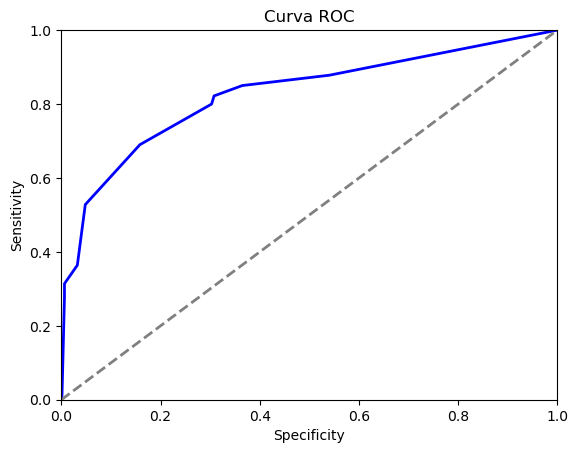

In [46]:
#Curva ROC
fpr, tpr, _ = roc_curve(titanic_metricas['survival'], titanic_metricas['y_chapeu'])
area_curva_roc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Linha de referência
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Curva ROC')
plt.show()

In [47]:
# calculando AUC
auc = sklearn.metrics.roc_auc_score(titanic_metricas['survival'], titanic_metricas['y_chapeu'])
auc

0.8264202719406675